We need to add 

(1) EM updates of the parameters of the prior on beta (spike + mixture of Gaussinans) ~ Theta, Theta_T; <br>
(2) Parameters of p y | z ~  gamma_{epsilon, t}. These are the parameters of the Weibull / Gumbell distributions for instance

In [1]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch

In [2]:
# vampW code
# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior:
    la = 0.5
    # Variances of the Gaussians in the mixture
    sigmas = [1]
    # Weights of the Gaussians in the mixture
    omegas = [1]
    def __init__(self, la, sigmas, omegas):
        self.la = la
        self.sigmas = sigmas
        self.omegas = omegas
    
def den_beta(r,gam1,prior): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))

    # How is this derived???
    # Is the sigma coming from the prior???
    # Note that gam1 * r / (gam1 + 1/sigma) = r / (1+1/(sigma*gam1)) = sigma * r / (sigma + 1/gam1)
    # This is equivalent to the formulation in the paper
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio



def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    # This is the negative of what is in the Overleaf. Still, this needs to be = 0 so *=-1 doesn't change the outcome
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    """
    Performs component-wise optimization of the parameters z_i
    We assume independence of parameters of z_i 
    """
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    # This is the second derivative of the expression g(z) to be maximized with the MAP estimation
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################

        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )

        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu) 

        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z


In [3]:
from numpy import random
import numpy as np
import sympy

emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    # Isn't this logY_i = mu + xi.T beta + c(wi + emc)
    # logY_i = mu + xi.T beta + c(wi - Ewi), wi = - standard Gumbel distribution

    # beta is mx1 vector 
    # mu is nx1 vector 
    # h2 is the heritability parameter
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)

    varwi = np.pi * np.pi / 6
    
    # If h2 is heritability, this contradicts the initialization of alpha.
    # Why is this different from overleaf section "initialization of hyperparameter alpha?"
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    # c = np.sqrt((1-h2) * sigmaG / varwi)

    # Why does the - arise here?
    wi = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # wi = random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp( mu + g + c * (wi + emc) )
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha
    
    

gam1 =  0.01
Var(y) =  0.1445859084892214
tau1 =  0.1
alpha =  3.015197732380088
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.54757845950421
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:60: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.5132665920827235
l2 error for z1_hat =  0.8601907564287883
v1 =  0.1593614632723912
true tau2 =  3.1238754887478013
tau2 = 0.5275042783026744
->LMMSE
corr(x2_hat, beta_true) =  [[0.04844431]]
l2 error for x2_hat =  0.9992917241129222
alpha2 =  0.9146709884438229
true gam1 =  1.474004038050308
gam1 =  0.2353274851362921
corr(z2_hat, beta_true) =  [[0.8129916]]
l2 error for z2_hat =  0.7067803114674155
true tau1 =  5.603604407013439
tau1 =  5.654499575748621


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.0449556]
corr(x1_hat, beta_true) =  0.04849035927416807
l2 error for x1_hat =  0.9989947055997442
B / (A+B) =  [0.38614552]
gam1 / (gam1 + 1/sigma) =  0.19049805656216637
alpha1 part I =  [0.07355997]
alpha2 part II =  [0.00429782]
alpha1 =  0.07243820834716448
true gam2 =  2.547580891298418
gam2 =  3.0133376945499712
corr(z1_hat, X*beta_true) =  0.9220537781127174
l2 error for z1_hat =  0.42266106269529596
v1 =  0.5585515337537852
true tau2 =  

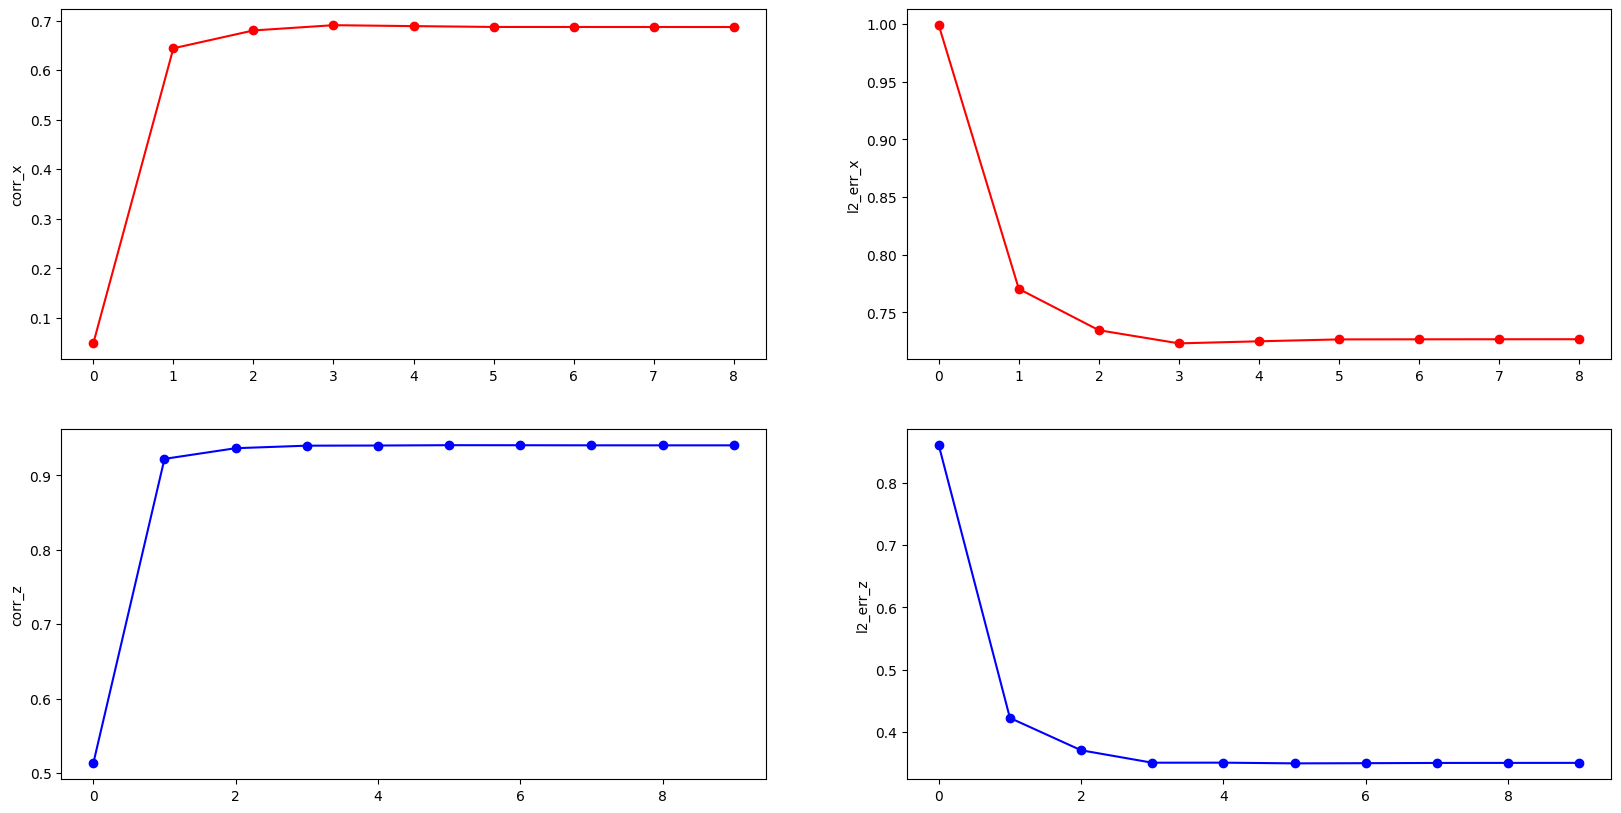

In [4]:
from tteVAMP.em import *

# running simulation
from numpy import random
import matplotlib.pyplot as plt

n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

# These are the initial estimates
# gam1 = 1.0 / (sigma)
gam1 = 1e-2

print("gam1 = ", gam1)
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
mu = 0

print("Var(y) = ", np.var(y))
# tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.ylabel('corr_x')
plt.plot(range(maxiter-1), corrs_x, 'ro-')
plt.subplot(222)
plt.ylabel('l2_err_x')
plt.plot(range(maxiter-1), l2_errs_x, 'ro-')
plt.subplot(223)
plt.ylabel('corr_z')
plt.plot(range(maxiter), corrs_z, 'bo-')
plt.subplot(224)
plt.ylabel('l2_err_z')
plt.plot(range(maxiter), l2_errs_z, 'bo-')
plt.show()

In [5]:
import scipy
import numpy as np
import math
import sympy 

### CONSTANTS ###
# Euler -Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

### WEIBULL MODEL ###
def update_Weibull_alpha_eq(alpha, y, mu, z_hat, xi):
    n,_ = y.shape
    out = np.zeros(n)
    res = np.log(y) - mu - z_hat
    out = np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
    return out

def update_Weibull_alpha(y, mu, z_hat, alpha_old, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
    if isinstance(alpha_new, np.ndarray) or isinstance(alpha_new, list): alpha_new = float(alpha_new[0])
    return alpha_new

def update_Weibull_mu(y, mu_old, z_hat, alpha, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    n,_ = y.shape
    mu_new = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))
    if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
    return mu_new

In [6]:
import numpy as np
def weibull_likelihood(z_hat, Y, a, mu, xi):
    ans = 0
    for i, z_i in enumerate(z_hat):
        z_hat_i = z_hat[i]
        z_hat = z_hat_i
        K = emc
        term1 = np.exp(-a * mu - a * z_hat - K)
        term2 = Y ** a * np.exp(a ** 2 / (2 * xi))
        term3 = a * np.exp(a * z_hat + K) * mu
        term4 = (np.exp(K) * a * z_hat - np.exp(K) * np.log(Y) * a + K * np.exp(K)) * np.exp(a * z_hat)
        term5 = np.exp(a * mu)

        ans += -term1 * (term2 + (term3 + term4) * term5)
    return ans

In [35]:
import torch
import torch.optim as optim

optimizer = optim.Adam([torch.tensor(0.01, requires_grad=True)], lr=0.1)

# Define the Weibull likelihood function in PyTorch
def weibull_likelihood(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)

def update_params(optimizer, z_hat, Y, a, mu, xi, K=emc):
    # Convert data to PyTorch tensors
    z_hat = torch.tensor(z_hat, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    xi = torch.tensor(xi, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    a = torch.tensor(a, dtype=torch.float32, requires_grad=True)
    mu = torch.tensor(mu, dtype=torch.float32, requires_grad=True)

    # Optimization step
    for step in range(100):  # Number of optimization steps
        optimizer.zero_grad()
        loss = -weibull_likelihood(z_hat, Y, a, mu, xi, K)  # Negate to maximize
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}, a: {a.item()}, mu: {mu.item()}")

    print(f"Final a: {a.item()}, Final mu: {mu.item()}")
    return a.item(), mu.item()

# Example usage
# Assuming z_hat, Y, a, mu, xi, and K are defined
# a_value, mu_value = update_params(optimizer, z_hat, Y, a, mu, xi, K)


In [20]:
# Define the Weibull likelihood function in PyTorch
def weibull_likelihood(z, z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)

def update_params(optimizer, z_hat, Y, a, mu, xi, K):
    # Convert data to PyTorch tensors
    z_hat = torch.tensor(z_hat, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    xi = torch.tensor(xi, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    # Optimization step
    for step in range(100):  # Number of optimization steps
        optimizer.zero_grad()
        loss = -weibull_likelihood(z_hat, z_hat, Y, a, mu, xi, K)  # Negate to maximize
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}, a: {a.item()}, mu: {mu.item()}")

    print(f"Final a: {a.item()}, Final mu: {mu.item()}")
    return a.item(), mu.item()


In [44]:
import torch
import torch.optim as optim

# Initial values for a and mu
a = torch.tensor(0.01, requires_grad=True)
mu = torch.tensor(0.01, requires_grad=True)

# Define the optimizer to update a and mu
optimizer = optim.Adam([a, mu], lr=0.0001)

# Define the Weibull likelihood function in PyTorch
def weibull_likelihood(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)

def update_params(optimizer, z_hat, Y, a, mu, xi, K):
    # Convert data to PyTorch tensors
    z_hat = torch.tensor(z_hat, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    xi = torch.tensor(xi, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    # Optimization step
    for step in range(10000):  # Number of optimization steps
        optimizer.zero_grad()
        loss = -weibull_likelihood(z_hat, Y, a, mu, xi, K)  # Negate to maximize
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}, a: {a.item()}, mu: {mu.item()}")

    print(f"Final a: {a.item()}, Final mu: {mu.item()}")
    return a.item(), mu.item()

# Example usage
z_hat = [0.1, 0.2, 0.3]
Y = [0.5, 0.6, 0.7]
xi = 0.8
K = 0.9
update_params(optimizer, z_hat, Y, a, mu, xi, K)


Step 0, Loss: 3.9328174591064453, a: 0.00989999994635582, mu: 0.00989999994635582
Step 10, Loss: 3.931480884552002, a: 0.008900127373635769, mu: 0.00890465546399355
Step 20, Loss: 3.9301514625549316, a: 0.007900813594460487, mu: 0.007931185886263847
Step 30, Loss: 3.928828239440918, a: 0.006902429740875959, mu: 0.006997863296419382
Step 40, Loss: 3.92751407623291, a: 0.00590520678088069, mu: 0.006120848469436169
Step 50, Loss: 3.926206588745117, a: 0.004909245762974024, mu: 0.005314442794770002
Step 60, Loss: 3.9249062538146973, a: 0.003914561588317156, mu: 0.004592187702655792
Step 70, Loss: 3.9236133098602295, a: 0.0029211153741925955, mu: 0.003967972472310066
Step 80, Loss: 3.9223263263702393, a: 0.0019288335461169481, mu: 0.0034567816182971
Step 90, Loss: 3.9210448265075684, a: 0.0009376192465424538, mu: 0.003074989188462496
Step 100, Loss: 3.9197683334350586, a: -5.264554783934727e-05, mu: 0.002840176923200488
Step 110, Loss: 3.9184961318969727, a: -0.001042097108438611, mu: 0.002

(-0.34078332781791687, 1.0863604545593262)

gam1 =  0.01
Var(y) =  0.5918558329223335
tau1 =  0.1
alpha =  2
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.722932826531883
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:60: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  -0.32213698035399657
l2 error for z1_hat =  2.4301342827854597
v1 =  0.14116756015582282
true tau2 =  1.9861761092451975
tau2 = 0.6083780430122794
Changing mu from 1 to 1.570503838991303
->LMMSE
corr(x2_hat, beta_true) =  [[-0.03040006]]
l2 error for x2_hat =  1.0143375666182404
alpha2 =  0.9040496909450626
true gam1 =  0.9315622959828245
gam1 =  0.26772869374156516
corr(z2_hat, beta_true) =  [[-0.3813851]]
l2 error for z2_hat =  2.3631070974396335
true tau1 =  5.995744386253184
tau1 =  5.732175197560879


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.12301312]
corr(x1_hat, beta_true) =  -0.030852688020850956
l2 error for x1_hat =  1.0110334219926054
B / (A+B) =  [0.37189906]
gam1 / (gam1 + 1/sigma) =  0.21118768949797348
alpha1 part I =  [0.0785405]
alpha2 part II =  [1.26517567e-08]
alpha1 =  0.08196089333152465
true gam2 =  2.722581147578292
gam2 =  2.9988132247149113
corr(z1_hat, X*beta_true) =  -0.309652907705915
l2 error for z1_hat =  2.789

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/2267076225.py:15: RuntimeWarning: overflow encountered in exp
  out = np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:28: RuntimeWarning: invalid value encountered in divide
  ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:37: RuntimeWarning: invalid value encountered in divide
  print("B / (A+B) = ", B[1] / (A[1]+B[1]))
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:40: RuntimeWarning: invalid value encountered in divide
  BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:42: RuntimeWarning: invalid value encountered in divide
  print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1]

corr(z1_hat, X*beta_true) =  -0.37995618344571197
l2 error for z1_hat =  992.3516731140629


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/518280119.py:67: RuntimeWarning: overflow encountered in exp
  den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/4031075610.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  tau2 = tau1 * (1-beta_1) / beta_1
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/4031075610.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, tau1 / beta_1)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/2267076225.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_47146/4031075610.py:83: Runt

v1 =  0.0
true tau2 =  0.005754956641303065
tau2 = inf
Changing mu from 3.183135798260346 to inf
->LMMSE
corr(x2_hat, beta_true) =  [[nan]]
l2 error for x2_hat =  nan
alpha2 =  nan
true gam1 =  nan
gam1 =  nan
corr(z2_hat, beta_true) =  [[nan]]
l2 error for z2_hat =  nan
true tau1 =  nan
tau1 =  nan


**** iteration =  9  **** 

->DENOISING
x1_hat[2] =  [nan]
corr(x1_hat, beta_true) =  nan
l2 error for x1_hat =  nan
B / (A+B) =  [nan]
gam1 / (gam1 + 1/sigma) =  nan
alpha1 part I =  [nan]
alpha2 part II =  [nan]
alpha1 =  nan
true gam2 =  nan
gam2 =  nan
corr(z1_hat, X*beta_true) =  nan
l2 error for z1_hat =  nan
v1 =  nan
true tau2 =  nan
tau2 = nan
->LMMSE
corr(x2_hat, beta_true) =  [[nan]]
l2 error for x2_hat =  nan
alpha2 =  nan
true gam1 =  nan
gam1 =  nan
corr(z2_hat, beta_true) =  [[nan]]
l2 error for z2_hat =  nan
true tau1 =  nan
tau1 =  nan




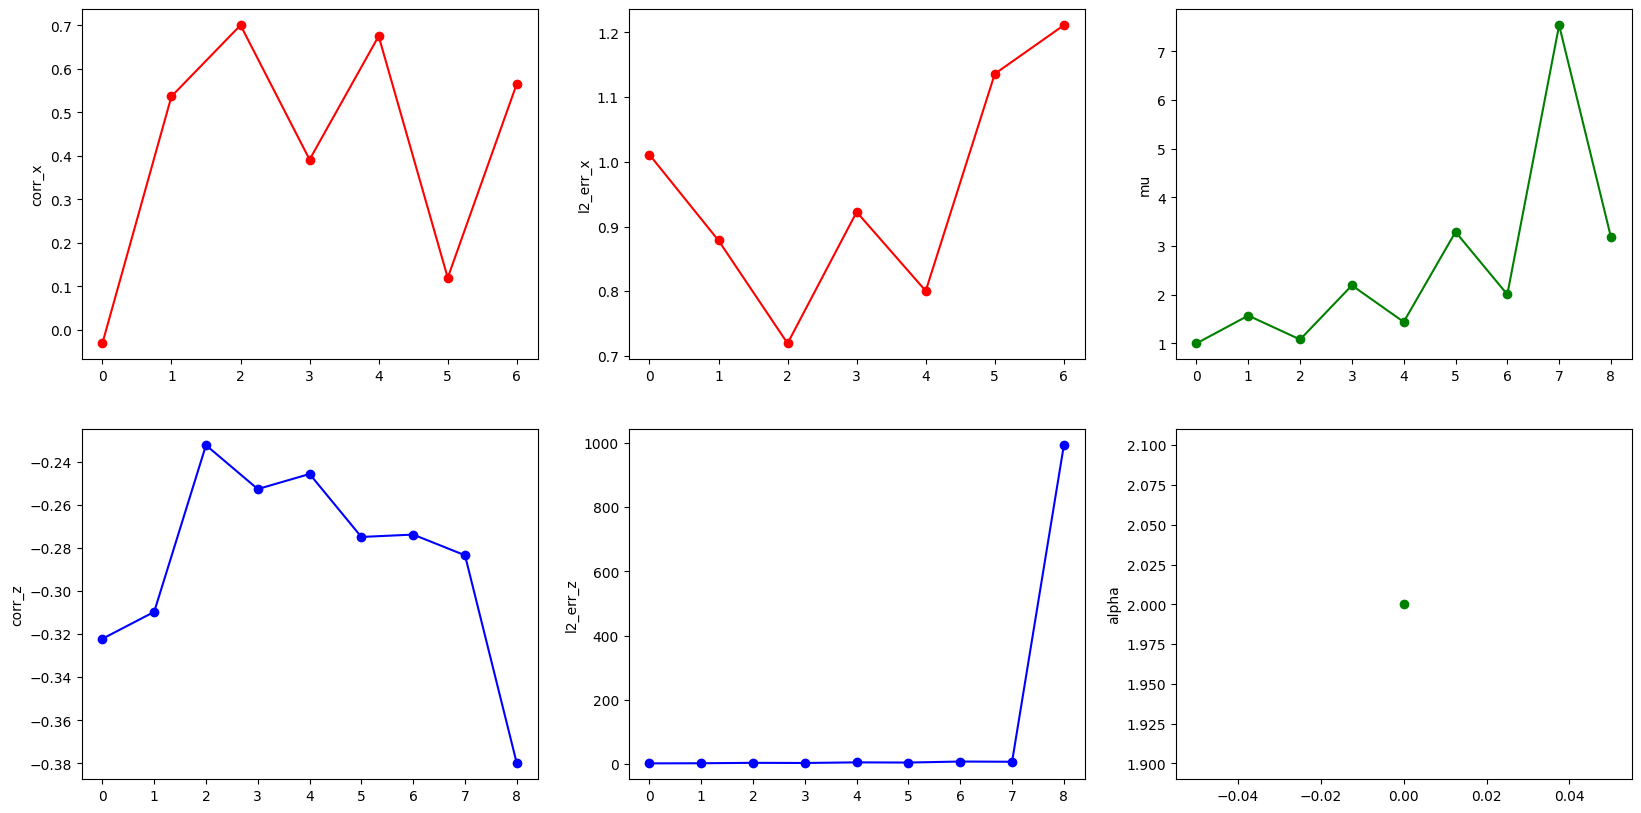

In [48]:
def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################

        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        

        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu)
        # print("\n\n\n")
        # print(f"Alpha new: {alpha_new}; type: {type(alpha_new)}")
        

        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, tau1 / beta_1)
        # alpha = torch.tensor(float(alpha), requires_grad=True)
        # mu = torch.tensor(float(mu), requires_grad=True)

        # optimizer = optim.Adam([alpha, mu], lr=0.0001)
        
        # alpha, mu = update_params(optimizer, z1_hat, y, alpha, mu, tau1 / beta_1, K=emc)
        
        # alphas.append(alpha)
        # mus.append(mu)
        # if(not np.isnan(alpha_new)): 
        #     print(f"Changing alpha from {alpha} to {alpha_new}")
        #     alpha = alpha_new
        # alphas.append(alpha)
        mu_new = update_Weibull_mu(y, mu, p1, alpha, tau1 / beta_1)
        if(not np.isnan(mu_new)):  
            print(f"Changing mu from {mu} to {mu_new}")
            mu = mu_new
        mus.append(mu)
        # if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
            


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas

n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

# These are the initial estimates
# gam1 = 1.0 / (sigma)
gam1 = 1e-2

print("gam1 = ", gam1)
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
# mu = 0
mu = 1
alpha = 2
print("Var(y) = ", np.var(y))
# tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

plt.figure(figsize=(20, 10))

# Plotting corr_x
plt.subplot(231)
plt.ylabel('corr_x')
plt.plot(range(len(corrs_x)), corrs_x, 'ro-')

# Plotting l2_err_x
plt.subplot(232)
plt.ylabel('l2_err_x')
plt.plot(range(len(l2_errs_x)), l2_errs_x, 'ro-')

# Plotting corr_z
plt.subplot(234)
plt.ylabel('corr_z')
plt.plot(range(len(corrs_z)), corrs_z, 'bo-')

# Plotting l2_err_z
plt.subplot(235)
plt.ylabel('l2_err_z')
plt.plot(range(len(l2_errs_z)), l2_errs_z, 'bo-')

# Plotting mu evolution
plt.subplot(233)
plt.ylabel('mu')
plt.plot(range(len(mus)), mus, 'go-')

# Plotting mu evolution
plt.subplot(236)
plt.ylabel('alpha')
plt.plot(range(len(alphas)), alphas, 'go-')

plt.show()

In [30]:
type(mu)

int

In [27]:
alpha.item()

3.076842942921509

In [36]:
alphas

[np.float64(2.8989540380554306),
 array([-0.10557058]),
 array([-0.11182364]),
 array([-0.14192316]),
 array([-0.14422395]),
 array([-0.15964049]),
 array([-0.16150944]),
 array([-0.17064663]),
 array([-0.17199615]),
 array([-0.17753439]),
 array([-0.17845821])]

In [28]:
mus

[np.float64(1.6683259383156788),
 array([-1.71080246]),
 array([6.95024597]),
 array([-22.86593764]),
 array([10.24815165]),
 array([-19.83271913]),
 array([21.06256277]),
 array([-32.73353574]),
 array([31.40583042]),
 array([-39.28507333])]

In [7]:
# old_prior = pr
def update_Prior(old_prior, r1, gam1):
    print(old_prior.sigmas.shape)
    print(old_prior.omegas.shape)
    prior = old_prior
    r1 = np.asmatrix(r1)
    omegas = np.transpose(np.asmatrix(old_prior.omegas))
    sigmas = np.transpose(np.asmatrix(old_prior.sigmas))
    sigmas_max = np.max(old_prior.sigmas)
    gam1inv = 1.0/gam1
    # np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv)) has shape = (P,L) and  omegas / np.sqrt(gam1inv + sigmas) has shape = (1, L)
    t1 = np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv))
    t2 = omegas / np.sqrt(gam1inv + sigmas)
    beta_tilde=np.multiply( t1, t2 )
    sum_beta_tilde = beta_tilde.sum(axis=1)
    beta_tilde=beta_tilde / sum_beta_tilde
    # pi.shape = (P, 1)
    pi = 1.0 / ( 1.0 + (1-prior.la * np.exp(-np.power(np.transpose(r1),2) / 2 * sigmas_max * gam1 / (sigmas_max + gam1inv) ) / np.sqrt(gam1inv) ) / sum_beta_tilde )
    gamma = np.divide(np.transpose(r1) * gam1, gam1 + 1.0/sigmas )
    # v.shape = (1,L)
    v = 1.0 / (gam1 + 1.0/sigmas)

    #updating sparsity level
    prior.la = np.mean(pi)
    #updating variances in the mixture
    prior.sigmas = (np.transpose(pi) @ np.multiply( beta_tilde , (np.power(gamma,2) + v)) ) / (np.transpose(pi) @ beta_tilde)
    #updating prior probabilities in the mixture
    prior.omegas = (np.transpose(pi) @ beta_tilde ) / np.sum(pi)
    return prior

In [8]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / (A+B) / (A+B)
    
    return ratio, ratio_der

In [9]:
A = (1-prior.la) * norm.pdf(r1, loc=0, scale=np.sqrt(1.0/gam1))
A.shape

(800, 1)

**** iteration =  0  **** 

EM Update of the prior of the coefficients beta
->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.31320304]
gam1 / (gam1 + 1/sigma) =  0.5320734116335684
alpha1 part I =  [0.16664701]
alpha2 part II =  [0.]
alpha1 =  0.1666470094930044
true gam2 =  2.4309597189322987
gam2 =  5.6862415918935305


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_24837/4244328499.py:66: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.9023427917849889
l2 error for z1_hat =  0.4326031365829108
v1 =  0.016086168389346366
true tau2 =  5.767069186833712
tau2 = 6.11652077608665
->LMMSE
corr(x2_hat, beta_true) =  [[0.63362064]]
l2 error for x2_hat =  0.7970947640516303
alpha2 =  0.7262357306844116
true gam1 =  1.5703113744349506
gam1 =  2.143504799866568
corr(z2_hat, beta_true) =  [[0.96612632]]
l2 error for z2_hat =  0.3142350622697406
true tau1 =  7.982397303754855
tau1 =  16.225769513942694


**** iteration =  1  **** 

EM Update of the prior of the coefficients beta
->DENOISING
x1_hat[2] =  [0.04278697]
corr(x1_hat, beta_true) =  0.6560141445177422
l2 error for x1_hat =  0.7700931607096227
B / (A+B) =  [0.52017467]
gam1 / (gam1 + 1/sigma) =  0.6818837368906048
alpha1 part I =  [0.35469865]
alpha2 part II =  [0.36042767]
alpha1 =  0.46299229653968654
true gam2 =  2.415642259945946
gam2 =  2.486172229074738
corr(z1_hat, X*beta_true) =  0.9685523012321764
l2 error for z1_hat =  0.2780294945

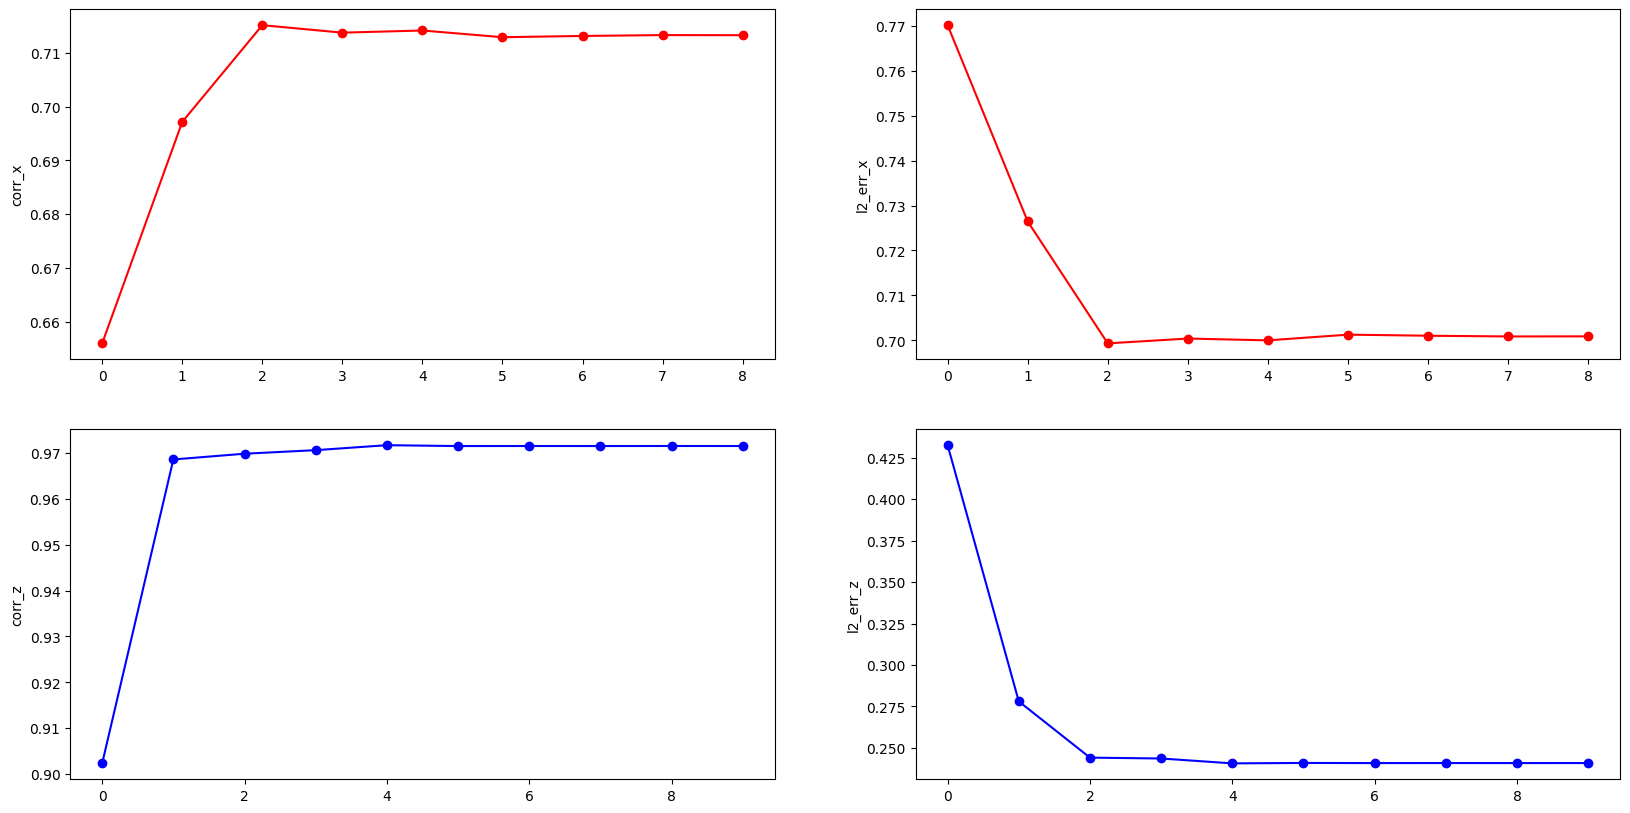

In [10]:
def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        print("EM Update of the prior of the coefficients beta")
        # prior = update_Prior(prior, r1, gam1)
        
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        # x1_hat, den_beta_der = den_beta_mixture(r1, gam1, prior)
        x1_hat = den_beta(r1, gam1, prior)

        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################

        # This seems to be different from overleaf
        # But in fact these two are equivalent
        # alpha1 = np.mean( den_beta_der )
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )

        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu) 

        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z

# pr = prior(la = la, sigmas = np.array([1 for _ in range(X.shape[1])]), omegas = np.array([1/X.shape[1] for _ in range(X.shape[1])]) )
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.ylabel('corr_x')
plt.plot(range(maxiter-1), corrs_x, 'ro-')
plt.subplot(222)
plt.ylabel('l2_err_x')
plt.plot(range(maxiter-1), l2_errs_x, 'ro-')
plt.subplot(223)
plt.ylabel('corr_z')
plt.plot(range(maxiter), corrs_z, 'bo-')
plt.subplot(224)
plt.ylabel('l2_err_z')
plt.plot(range(maxiter), l2_errs_z, 'bo-')
plt.show()


In [11]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / ((A+B)**2)
    
    return ratio, ratio_der

In [12]:
p = update_Prior(pr, r1, 1)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    print(A.shape)
    print(r.shape)
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

In [ ]:
den_beta_mixture(r1, 1, pr)

(array([[0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0.32037724],
        [0

In [ ]:
der_den_beta(r1, 1, pr)

B / (A+B) =  [0.32037724]
(800, 1)
(800, 1)
gam1 / (gam1 + 1/sigma) =  0.5
alpha1 part I =  [0.16018862]
alpha2 part II =  [0.]


array([[0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.16018862],
       [0.160

In [ ]:
p.omegas.shape

(800, 800)

In [ ]:
p.sigmas.shape

(800, 800)

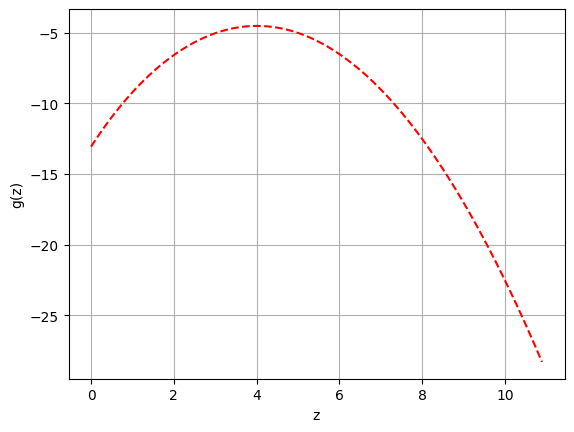

In [ ]:
# plotting function g(z)

import numpy as np
import sympy
import matplotlib.pyplot as plt

emc = float( sympy.S.EulerGamma.n(10) )

tau1 = 1
p = 5
mu = 0
alpha = 1
y = 1

def g(z):
    return -alpha * z - np.power(y, alpha) * np.exp(-alpha*(z+mu) - emc) - (z-p)*(z-p)*tau1/2 

net = np.arange(0, 11.0, 0.1)

plt.figure()
plt.plot(net, g(net), 'r--')
plt.grid(True)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.savefig('gz.png')
plt.show()